Refracted gaussian processes code

In [1]:
import numpy as np
import numpy.matlib as matlib
import pandas as pd
import scipy.linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib

SET PLOT PARAMS FOR CONSISTENCY

In [2]:
### plot font size params ###

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 22

plt.rc('font', family='serif',size=MEDIUM_SIZE, weight = 'bold')
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize = MEDIUM_SIZE, labelweight = 'bold')     # fontsize of the axes title, x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
matplotlib.rc('text', usetex=True)


Kernel Functions

In [45]:
# Squared exponential covariance function
def Kexp(hyps,x1,x2):
    '''
    Covariance matrix calculation with some vectorisation techniques
    
    Parameters:
    ----------
    hyps : Numpy array/list
        Array of hyperparameters, hyps[0] - amplitude, hyps[1:] - length scales
    x1 : Numpy array
        Array of points to evaluate covariance against x2
    x2 : Numpy array
        Array of points to evaluate covariance against x1
    '''
    n1 = x1.shape[0]
    m = x1.shape[1]
    n2 = x2.shape[0]
    
    a = float( hyps[0] )
    d = hyps[1:]

    Ksum = np.zeros( (n1,n2) )

    for i in range(0,m): 

        Kdiff = np.tile( x1[:,i] , (n2,1) ).T - np.tile( x2[:,i] , (n1,1) )
        
        Ksum += float( -0.5 * d[i] ) * np.square(Kdiff) 
    
    K = a * np.exp(Ksum)
    
    return K

# Matern 3/2 covariance function
def Km3_2(hyps,x1,x2):
    '''
    Covariance matrix calculation with some vectorisation techniques
    
    Parameters:
    ----------
    hyps : Numpy array/list
        Array of hyperparameters, hyps[0] - amplitude, hyps[1:] - length scales
    x1 : Numpy array
        Array of points to evaluate covariance against x2
    x2 : Numpy array
        Array of points to evaluate covariance against x1
    '''
    n1 = x1.shape[0]
    m = x1.shape[1]
    n2 = x2.shape[0]
    
    a = float( hyps[0] )
    d = hyps[1:]

    Ksum1 = np.zeros( (n1,n2) )
    Ksum2 = np.zeros( (n1,n2) )

    for i in range(0,m): 

        Kdiff = np.abs(np.tile( x1[:,i] , (n2,1) ).T - np.tile( x2[:,i] , (n1,1) ))
        
        Ksum1 += float( -np.sqrt(3)*d[i] ) * Kdiff
         
        Ksum2 += float(np.sqrt(3) * d[i] ) * Kdiff
    
    K = a * (1 + Ksum2) * np.exp( Ksum1 )
    
    return K

# Matern 5/2 covariance function
def Km5_2(hyps,x1,x2):
    '''
    Covariance matrix calculation with some vectorisation techniques
    
    Parameters:
    ----------
    hyps : Numpy array/list
        Array of hyperparameters, hyps[0] - amplitude, hyps[1:] - length scales
    x1 : Numpy array
        Array of points to evaluate covariance against x2
    x2 : Numpy array
        Array of points to evaluate covariance against x1
    '''
    n1 = x1.shape[0]
    m = x1.shape[1]
    n2 = x2.shape[0]
    
    a = float( hyps[0] )
    d = hyps[1:]

    Ksum1 = np.zeros( (n1,n2) )
    Ksum2 = np.zeros( (n1,n2) )
    Ksum3 = np.zeros( (n1,n2) )

    for i in range(0,m): 

        Kdiff = np.abs(np.tile( x1[:,i] , (n2,1) ).T - np.tile( x2[:,i] , (n1,1) ))
        
        Ksum1 += float( -np.sqrt(5)*d[i] ) * Kdiff
        
        Ksum2 += float( (5*d[i]**2)/3 ) * np.square(Kdiff)  
        
        Ksum3 += float(np.sqrt(5) * d[i] ) * Kdiff
    
    K = a * (1 + Ksum3 + Ksum2) * np.exp( Ksum1 )
    
    return K

def Krq(hyps,x1,x2):
    '''
    Covariance matrix calculation with some vectorisation techniques
    
    Parameters:
    ----------
    hyps : Numpy array/list
        Array of hyperparameters, hyps[0] - amplitude, hyps[1] - reciprical of scale mixture parameter, hyps[2:] - reciprical length scales
    x1 : Numpy array
        Array of points to evaluate covariance against x2
    x2 : Numpy array
        Array of points to evaluate covariance against x1
    '''
    n1 = x1.shape[0]
    m = x1.shape[1]
    n2 = x2.shape[0]
    
    a = float( hyps[0] )
    omega = float(hyps[1])
    d = hyps[2:]

    Ksum = np.zeros( (n1,n2) )

    for i in range(0,m): 

        Kdiff = np.tile( x1[:,i] , (n2,1) ).T - np.tile( x2[:,i] , (n1,1) )
        
        Ksum += float(0.5 * omega * d[i] ) * np.square(Kdiff) 
    
    K = a * (1 + Ksum)**(-omega)
    
    return K

# derivative of SE w.r.t d hyper-parameter
def dKexp(K,d,x):
    '''
    First order derivative of covariance function w.r.t. length scale parameter with some vectorisation techniques
    
    Parameters:
    ----------
    K : Numpy array
        Covariance matrix evaluated on domain x
    d : float
        Length scale parameter
    x : Numpy array
        Domain
    '''
    n = x.shape[0]

    # for i in range(1,m+1):
        
    #     Kdiff = np.tile( x[:,i-1] , (n,1) ).T - np.tile( x[:,i-1] , (n,1) )
    #     d = float( hypsK[i] ) 
    #     DdQ = np.multiply( np.matrix( -d/2 * np.square(Kdiff) ) , K ) # pointwise multiplication
    #     Jac[i] = traceAB(invQ,DdQ) - yTinvQ @ DdQ @ yTinvQ.transpose()
    
    Kdiff = np.tile( x , (n,1) ).T - np.tile( x , (n,1) )
    DdQ = np.multiply( np.matrix( -d/2 * np.square(Kdiff) ) , K ) # pointwise multiplication
    
    return DdQ

# Matern 5/2 covariance function
def dKm5_2(K,d,x):
    '''
    First order derivative of covariance function w.r.t. length scale parameter with some vectorisation techniques
    
    Parameters:
    ----------
    K : Numpy array
        Covariance matrix evaluated on domain x
    d : float
        Length scale parameter
    x : Numpy array
        Domain
    '''
    n = x.shape[0]
    
    Kdiff = np.abs(np.tile( x , (n,1) ).T - np.tile( x , (n,1) ))
    Ksum1 = np.exp(np.sqrt(5)*d*Kdiff)
    Ksum2 = 1 + np.sqrt(5)*d*Kdiff
    Ksum3 = 5*d**2/3 * Kdiff**2
    
    DdQ = -Ksum3*Ksum2*Ksum1 
    
    return DdQ


# Rational quadratic covariance function
def dKrq(K,d,omega,x, wrt_omega = False):
    '''
    First order derivative of covariance function w.r.t. reciprical length scale parameter d with some vectorisation techniques
    
    Parameters:
    ----------
    K : Numpy array
        Covariance matrix evaluated on domain x
    d : float
        Length scale parameter
    omega : float
        Scale mixture parameter
    x : Numpy array
        Domain
    '''
    n = x.shape[0]
    
    if wrt_omega:
        m = x.shape[1]
        Ksum1 = np.zeros( (n,n) )
        Ksum2 = np.zeros( (n,n) )
        
        for i in range(m):
            Ksquare = np.abs(np.tile( x[:,i], (n,1) ).T - np.tile( x[:,i] , (n,1) ))**2
            Ksum1 += (1/omega)*np.log(1+Ksquare*omega* float( d[i])) 
            Ksum2 += Ksquare* float( d[i])/(1+Ksquare*omega* float( d[i]))

        DdQ = (Ksum1-Ksum2)*K

        return DdQ
    else:
        Ksquare = np.abs(np.tile( x, (n,1) ).T - np.tile( x , (n,1) ))**2
        Ksum1 = Ksquare*d
        Ksum2 = 1 + Ksquare*d*omega

        DdQ = -Ksum1*K/Ksum2
        
        return DdQ



MLE Functions (Generalised)

In [96]:
# Negative log-likelihood function (constants and scaling removed)
def nLL(log_hyps,K_func,dK_func,x,y):
    '''
    Calculates the negative log likelihood given kernel func, hyperparameters, inputs x and outputs y
    
    Parameters:
    ----------
    K_func : function
        Covariance function to calculate the nLL
    log_hyps : Numpy array/list
        Array of hyperparameters, length depends on func, log_hyps[-1] - noise variance
    x : Numpy array
        Array of points in the input domain
    y : Numpy array
        Outputs corresponding to the input points
    '''

    hypsK = np.exp ( log_hyps[:-1] )

    v =  np.exp( log_hyps[-1] ) 

    K = K_func(hypsK,x,x) 

    # Add noise variance and invert
    Q = diagAdd(v,K)
    invQ = la.inv(Q)

    # Numerically stable calculation  of logdet(Q)
    log_det = np.sum( np.log ( la.svd(Q)[1] ) )  

    negLogLike = float( np.transpose(y) @ invQ @ y + log_det )
    
    return negLogLike

# nLL Jacobian function
def DnLL(log_hyps,K_func, dK_func,x,y):
    '''
    Calculates the gradient of the negative log likelihood given kernel function, hyperparameters, inputs x and outputs y
    
    Parameters:
    ----------
    K_func : function
        Covariance function to calculate the nLL
    log_hyps : Numpy array/list
        Array of hyperparameters, length depends on func, log_hyps[-1] - noise variance
    x : Numpy array
        Array of points in the input domain
    y : Numpy array
        Outputs corresponding to the input points
    '''
    
    n = x.shape[0]
    m = x.shape[1]
    hypsK = np.exp ( log_hyps[:-1] )
    v = float( np.exp( log_hyps[-1] ) )
    
    K = K_func(hypsK,x,x) 
    
    # Add noise variance and invert
    Omega = diagAdd( v , np.matlib.zeros( (n,n) ) )
    Q = K + Omega 
    # Q = diagAdd( v , K)
    invQ = la.inv(Q)

    yTinvQ = np.transpose(y) @ invQ
    
    # DaQ = K
    # Jac[0] = traceAB(invQ,DaQ) - yTinvQ @ DaQ @ yTinvQ.transpose()

    # for i in range(1,m+1):
        
    #     Kdiff = np.tile( x[:,i-1] , (n,1) ).T - np.tile( x[:,i-1] , (n,1) )
    #     d = float( hypsK[i] ) 
    #     DdQ = np.multiply( np.matrix( -d/2 * np.square(Kdiff) ) , K ) # pointwise multiplication
    #     Jac[i] = traceAB(invQ,DdQ) - yTinvQ @ DdQ @ yTinvQ.transpose()

    if K_func.__name__ != 'Krq':
        Jac = np.zeros( (m+2,) )

        DaQ = K
        Jac[0] = traceAB(invQ,DaQ) - yTinvQ @ DaQ @ yTinvQ.transpose()
        
        for i in range(0,m):
            
            d = float( hypsK[i+1] )
            DdQ = dK_func(K,d,x[:,i])
            # Kdiff = np.tile( x[:,i-1] , (n,1) ).T - np.tile( x[:,i-1] , (n,1) )
            # d = float( hypsK[i] ) 
            # DdQ = -d/2*Kdiff**2*K # pointwise multiplication
            Jac[i+1] = traceAB(invQ,DdQ) - yTinvQ @ DdQ @ yTinvQ.transpose()

        DvQ = Omega
        Jac[m+1] = traceAB(invQ,DvQ) - yTinvQ @ DvQ @ yTinvQ.transpose()
        return Jac
    else:
        Jac = np.zeros( (m+3,) )
        DaQ = K
        Jac[0] = traceAB(invQ,DaQ) - yTinvQ @ DaQ @ yTinvQ.transpose()
            
        omega = float( hypsK[1] ) 
        d = hypsK[2:]
        DomegaQ = dK_func(K,d,omega,x,wrt_omega=True)
        Jac[1] = traceAB(invQ,DaQ) - yTinvQ @ DomegaQ @ yTinvQ.transpose()
        for i in range(0,m):
            DdQ = dK_func(K, float( d[i]),omega,x[:,i])
            Jac[i+2] = traceAB(invQ,DdQ) - yTinvQ @ DdQ @ yTinvQ.transpose()
    
        DvQ = Omega
        Jac[m+2] = traceAB(invQ,DvQ) - yTinvQ @ DvQ @ yTinvQ.transpose()
        return Jac
    

# Perform hyperparameter learning
def hypLearn_exp(K_func, dK_func,x,y, learn_rq = False):
    '''
    Perform MLE to estimate the hyperparameters from data. 
    Uses the scipy.optimize minimise method to minimise the negloglike.
    '''
    n = x.shape[0]
    m = x.shape[1]

    # define initial log_hyperparameter values for optimisation, drawing them from standard normal dist.
    if learn_rq:
        log_hyps0 = np.random.normal(0,1, (m+3,) )
        res = minimize( nLL , log_hyps0, (K_func,dK_func,x,y), method = 'BFGS', jac = DnLL, options = {'disp': True}  )
        hyps = np.exp( res.x )
        print('Learned hyperparameters [a,omega,d,v] = ', hyps)
    else:
        log_hyps0 = np.random.normal(0,1, (m+2,) )
        res = minimize( nLL , log_hyps0, (K_func,dK_func,x,y), method = 'BFGS', jac = DnLL, options = {'disp': True}  )
        hyps = np.exp( res.x )
        print('Learned hyperparameters [a,d,v] = ', hyps)
    
    return hyps

Stats Functions

In [60]:
def calc_rmse(actual,predicted):  
    return np.sqrt(np.square(np.subtract(actual,predicted)).mean() )

def CountUpcross(y):
    return np.sum([cross for cross in (y[1:] > 0) & (y[:-1] <= 0)])  

# Trace(A*B) function to save computational time
def traceAB(A,B): 
    '''
    Calculates trace of A*B
    '''
    # A and B assumed to be square
    n = A.shape[0]

    trace = float(0)

    for i in range(0,n):
        trace += float( A[i,:] @ B[:,i] ) 
    
    return trace

# diag-add function
def diagAdd(v,A):
    '''
    Adds scalar value to the diagonal of A
    '''
    # n = A.shape[0]
    B = np.copy(A)
    np.fill_diagonal(B, B.diagonal() + v) 
    

    # for i in range(0,n):
        
    #     A[i,i] += v

    return B

# GP predictions
def GPpred(K_func,hyps,x,y,x_pred):
    '''
    Make predictions on input domain x_pred.
    '''

    Kx = K_func(hyps[:-1],x,x)
    Q = diagAdd(hyps[-1],Kx)
    invQ = la.inv(Q)

    Kpx = K_func(hyps[:-1],x_pred,x)
    Kpp = K_func(hyps[:-1],x_pred,x_pred)
    
    pred = Kpx @ invQ @ y # GP prediction on x_pred

    cov = Kpp - Kpx @ invQ @ Kpx.transpose() # GP covariance matrix on x_pred
    std = np.sqrt( np.diag( cov ) ).reshape(-1,1) # GP standard deviations on x_pred

    return pred, std

Sample from GP

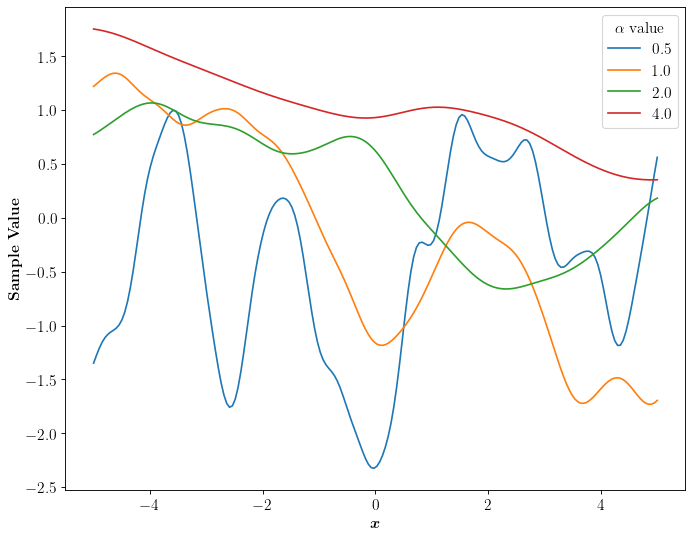

In [89]:
n = 200
xmin = -5
xmax = 5
x = np.linspace(xmin,xmax,n).reshape(-1,1)

# define hyps
a = 1
alphas = np.array([0.5,1,2,4])
omegas = 1/alphas
d = 1

plt.figure(figsize=(10,8), dpi = 80)
for i,omega in enumerate(omegas):
    Kx = Krq([a,omega,d],x,x)
    sqrtKx = np.real( la.sqrtm(Kx) )
    y = (np.random.normal(0,1, (1,n)) @ sqrtKx).reshape(-1,1) # draw from gp
    plt.plot(x,y, label = f'{alphas[i]}')
    
plt.ylabel(r'\textbf{Sample Value}')
plt.xlabel(r'\boldmath$x$')
plt.legend(title = r'$\alpha$ value')
plt.show()

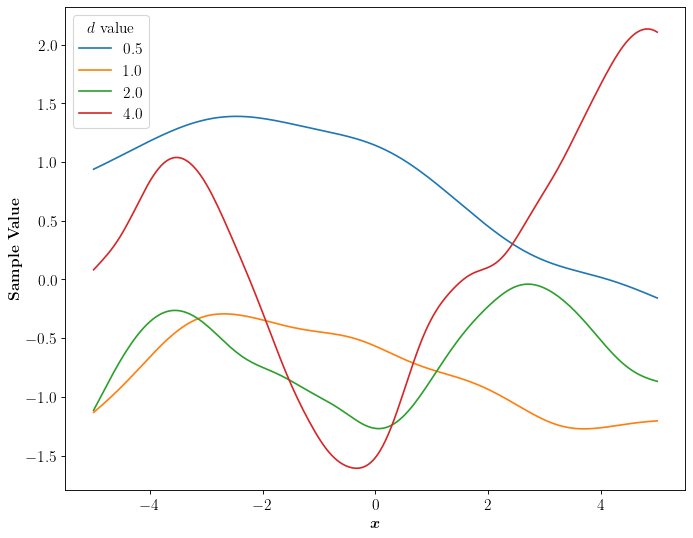

In [90]:
n = 200
xmin = -5
xmax = 5
x = np.linspace(xmin,xmax,n).reshape(-1,1)

# define hyps
a = 1
alpha = 1
omegas = 1/alpha
ds = np.array([0.5,1,2,4])

plt.figure(figsize=(10,8), dpi = 80)
for d in ds:
    Kx = Krq([a,omega,d],x,x)
    sqrtKx = np.real( la.sqrtm(Kx) )
    y = (np.random.normal(0,1, (1,n)) @ sqrtKx).reshape(-1,1) # draw from gp
    plt.plot(x,y, label = f'{d}')
    
plt.ylabel(r'\textbf{Sample Value}')
plt.xlabel(r'\boldmath$x$')
plt.legend(title = r'$d$ value')
plt.show()

In [7]:
sig = 0.05
plt.figure(figsize=(10,8), dpi = 80)
for i in range(6):
    if i<4:
        y = (np.random.normal(0,1, (1,n)) @ sqrtKx).reshape(-1,1) # draw from gp
        plt.plot(x,y, label = f'{i+1}', alpha = 0.5)
#     elif i == 4:
#         y = (np.random.normal(0,1, (1,n)) @ sqrtKx).reshape(-1,1) # draw from gp
#         plt.plot(x,y, label = f'{i+1}', alpha = 1, linewidth= 2, color = 'k')
#     else:
#         y_noise = (y + np.random.normal(0,sig, (n,1) ))   # draw from gp with noise
#         plt.scatter(x,y_noise, label = f'{i} + noise', alpha = 1, color = 'k')
        
plt.legend(title = r'\textbf{Sample}')
plt.ylabel(r'\textbf{Value}')
plt.xlabel(r'\boldmath$x$')
plt.show()

Add measurements and sample from posterior

In [8]:
# M = 3
# x_meas = 10*np.random.rand(M,1)
# y_meas = 10*(np.random.rand(M,1) - 0.5)

# K_x_meas = Krq([a,omega,d],x_meas,x_meas)

# K_x_joint = Krq([a,omega,d],x,x_meas)

# mu_post = K_x_joint@np.linalg.inv(K_x_meas)@y_meas
# K_post = Kx - K_x_joint@np.linalg.inv(K_x_meas)@K_x_joint.T
# std_post = np.sqrt(np.diag(K_post))

# sqrtK = np.real(scipy.linalg.sqrtm(K_post))

In [9]:
# for i in range(20):
#     w = np.random.randn(1,n)
#     f = (w@sqrtK).reshape(-1,1) + mu_post
#     plt.plot(x,f)

Example of Maximum Likelihood Estimation

         Current function value: 63.500338
         Iterations: 0
         Function evaluations: 40
         Gradient evaluations: 28
Learned hyperparameters [a,d,v] =  [2.38365311 1.62254002 0.77339045]


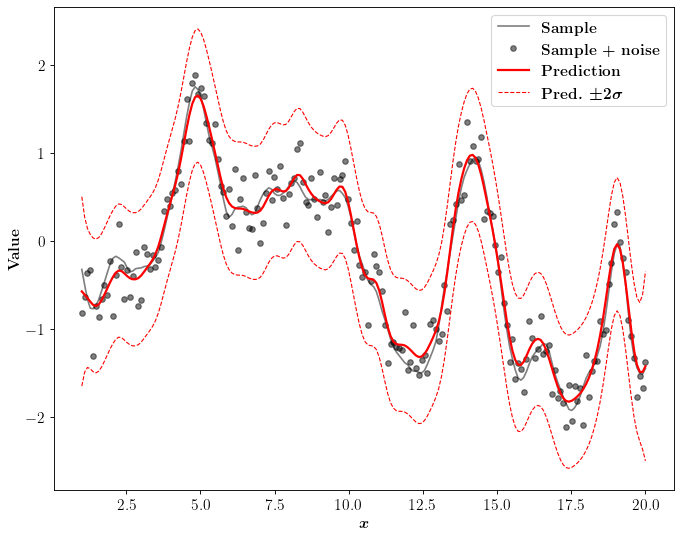

In [99]:
def testRun(Kfunc =Kexp, dKfunc = dKexp, x = None, y_sample = None, y_noise = None, count_upcrossing = False):
    '''
    One dimensional case, learning two hyperparameters from a sample of the GP prior with added noise.
    
    Parameters:
    ----------
    x : 1D numpy array
        Domain of the GP, none if samples are to be generated
    y_sample : 1D numpy array
        Samples from the GP over the domain, none if samples are to be generated
    y_noise : 1D numpy array
        Samples plus noise, none if samples are to be generated
    count_upcrossing : bool
        Count the number of upcrossings on the domain interval
    '''
    ## take sample if not provided
    if y_sample == None:
        n = 200
        xmin = 1
        xmax = 20
        x = np.linspace(xmin,xmax,n).reshape(-1,1)

        # define hyps
        if Kfunc.__name__ == 'Krq':
            a = 1
            omega = 1
            d = 1
            Kx = Kfunc([a,omega,d],x,x)
        else:
            a = 1
            d = 1
            Kx = Kfunc([a,d],x,x)

        
        sqrtKx = np.real( la.sqrtm(Kx) )

        sig = 0.25
        y_sample = (np.random.normal(0,1, (1,n))@sqrtKx).reshape(-1,1) 
        y_noise = y_sample + np.random.normal(0,sig, (n,1) )  

    # Hyperparameter training
    hyps = hypLearn_exp(Kfunc,dKfunc,x,y_noise, learn_rq = True ) if Kfunc.__name__ == 'Krq' else hypLearn_exp(Kfunc,dKfunc,x,y_noise)

    # Make predictions
    pred, std = GPpred(Kfunc,hyps,x,y_noise,x)
    # print(f'RMSE Prediction: {calc_rmse(pred,y_sample)}\nRMSE Noise: {calc_rmse(y_noise,y_sample)}')
    
    # if count_upcrossing:
    #     n_upcross = CountUpcross(pred)
    # print(f'Expected number of upcrossings in x on the interval: {(x[-1]-x[0])*np.sqrt(hyps[1])/(2*np.pi)}')
    
    plt.figure(figsize=(10, 8), dpi=80)
    plt.plot(x,y_sample,'k',label = r'\textbf{Sample}', alpha = 0.5)
    plt.plot(x,y_noise,'ko',label = r'\textbf{Sample + noise}', alpha = 0.5, markersize = 5)
    plt.plot(x,pred, color = 'red',label = r'\textbf{Prediction}', alpha = 1, linewidth = 2)
    plt.plot(x,pred + 2*std, color = 'red', linestyle = '--', linewidth = 1)
    plt.plot(x,pred - 2*std, color = 'red', linestyle = '--',linewidth = 1, label = r'\textbf{Pred.} \boldmath$\pm 2\sigma$')
    plt.xlabel(r'\boldmath$x$')
    plt.ylabel(r'\textbf{Value}')
    plt.legend()
    plt.show()

    return pred

# run test code
# nCount = []
# for _ in range(1):
y_pred = testRun(Kfunc =Km5_2, dKfunc = dKm5_2)#x = x, y_sample = y,y_noise=y_noise)
    # nCount += [CountUpcross(y_pred)]
# print(nCount)

In [6]:
def testRun2():
    '''
    Two dimensional case with data generated from trig function, estimating four hyperparameters
    '''
    n = 400
    x1min = -4*np.pi
    x1max = 4*np.pi
    # x2min = -2*np.pi
    # x2max = 2*np.pi
    
    # X1, X2 = np.meshgrid(
    #     np.linspace(x1min, x1max, n),
    #     np.linspace(x2min, x2max, n)
    # )
    # X = np.array([list(zip(x1,x2)) for x1,x2 in zip(X1,X2)]).reshape((n*n,2))
    X = np.linspace(x1min,x1max,n).reshape(-1,1)
    b=1
    f = np.cos(b*X) #+ np.cos(X[:,1])
    
    # f = np.cos(X)

    sig = 1.6
    y = f.reshape(-1,1) + np.random.normal(0,sig, (n,1) )

    # plot function surface
    # vmin, vmax = (-2.5,2.5)
    # norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    # levels = np.arange(vmin,vmax,0.1)
    # plt.figure(figsize=(8, 8), dpi=80)
    # plt.contourf(X, Y, y.reshape((n,n)),cmap='coolwarm',norm=norm, levels=levels)
    # plt.colorbar(label = r'\textbf{Function Value}')
    # plt.xlabel(r'\boldmath$x_1$')
    # plt.ylabel(r'\boldmath$x_2$')
    # plt.show()
  

    # Hyperparameter training
    hyps = hypLearn_exp(X,y)
    
    # set lengthscale to pther number
    # hyps[1] = b

    # # Make predictions
    pred, std = GPpred(hyps,X,y,X)
    print(f'RMSE Prediction: {calc_rmse(pred,f.reshape(-1,1))}\nRMSE Noise: {calc_rmse(f.reshape(-1,1),y)}')
    # print(f'Expected number of upcrossings in x1 on the interval: {(x1max-x1min)*np.sqrt(hyps[1])/(2*np.pi)}\nExpected number of upcrossings in x2 on the interval: {(x2max-x2min)*np.sqrt(2)*np.sqrt(hyps[2])/(2*np.pi)}')
    print(f'Expected number of upcrossings in x1 on the interval: {(x1max-x1min)*np.sqrt(hyps[1])/(2*np.pi)}')
    print(f'Actual number of upcrossings in x1 on the interval: {(x1max-x1min)*b/(2*np.pi)}')
    print(f'Ratio: {b**2/hyps[1]}')
    # # plot prediction as surface
    # plt.figure(figsize=(8, 8), dpi=80)
    # plt.contourf(X, Y, pred.reshape((n,n)),cmap='coolwarm',norm=norm, levels=levels)
    # plt.colorbar(label = r'\textbf{Function Value}')
    # plt.xlabel(r'\boldmath$x_1$')
    # plt.ylabel(r'\boldmath$x_2$')
    # plt.show()

    plt.figure(figsize=(10, 8), dpi=80, facecolor=(1,1,1))
    plt.plot(X,pred, label = 'pred')
    plt.plot(X,f, label = 'actual')
    # # plot slice
    # plt.figure(figsize=(10, 8), dpi=80)
    # plt.plot(X.reshape((n,n,2))[0,:,0],f.reshape((n,n))[0,:],'k',label = r'\textbf{Data}', alpha = 0.5)
    # plt.plot(X.reshape((n,n,2))[0,:,0],y.reshape((n,n))[0,:],'ko',label = r'\textbf{Data + noise}', alpha = 0.5, markersize = 5)
    # plt.plot(X.reshape((n,n,2))[0,:,0],pred.reshape((n,n))[0,:],color = 'red',label = r'\textbf{Prediction}', linewidth = 2)
    # plt.plot(X.reshape((n,n,2))[0,:,0],pred.reshape((n,n))[0,:]+ 2*std.reshape((n,n))[:,0], color = 'red', linestyle = '--', label = r'\boldmath$\pm 2 \sigma$',linewidth = 1)
    # plt.plot(X.reshape((n,n,2))[0,:,0],pred.reshape((n,n))[0,:] - 2*std.reshape((n,n))[:,0], color = 'red', linestyle = '--',linewidth = 1)
    plt.xlabel(r'\boldmath$x$')
    plt.ylabel(r'\textbf{Value}')
    # plt.title(r'\boldmath$x_2 = 0$')
    plt.legend()
    plt.show()
    return hyps
# run test code
testRun2()

TypeError: hypLearn_exp() missing 2 required positional arguments: 'x' and 'y'

Optimization terminated successfully.
         Current function value: -337.801657
         Iterations: 14
         Function evaluations: 19
         Gradient evaluations: 19
Learned hyperparameters [a,d,v] =  [0.52541998 2.07924749 0.03832359]


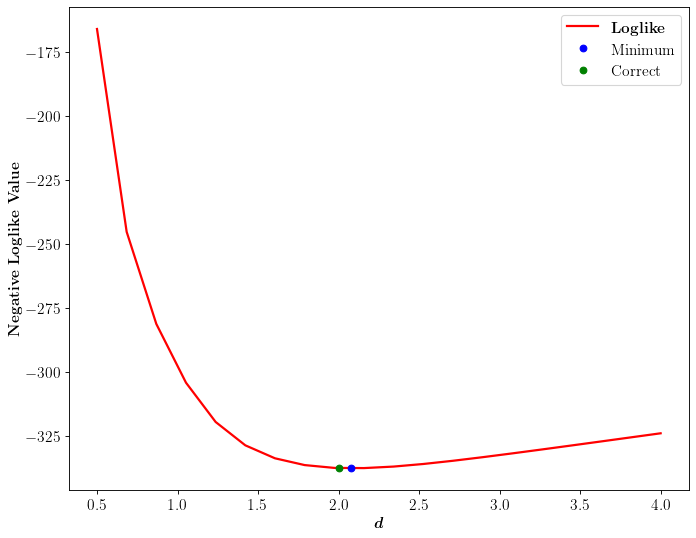

In [499]:
def testRun3(x = None, y_sample = None, y_noise = None):
    '''
    One dimensional case, learning two hyperparameters from a sample of the GP prior with added noise.
    Plotting the negative log likelihood against values of d with exact values of other hyps.
    '''
    ## take sample if not provided
    if y_sample == None:
        n = 200
        xmin = 1
        xmax = 20
        x = np.linspace(xmin,xmax,n).reshape(-1,1)

        # define hyps
        a = 1
        d = 2

        Kx = Kexp([a,d],x,x)
        sqrtKx = np.real( la.sqrtm(Kx) )

        sig = 0.2
        y_sample = (np.random.normal(0,1, (1,n))@sqrtKx).reshape(-1,1) 
        y_noise = y_sample + np.random.normal(0,sig, (n,1) )  
    
    # Hyperparameter training
    hyps = hypLearn_exp(x,y_noise)
    loglike_opt = nLL(np.log(hyps),x,y_noise)
    
    # calculate negative loglikelihood function
    phi_a = np.log(hyps[0])
    phi_v = np.log(hyps[2])
    loglike = []
    d_ar = np.linspace(0.5,4,20)
    loglike_act = nLL([phi_a, np.log(d), phi_v],x,y_noise)
    phi_d_ar = np.log(d_ar)
    for phi_d in phi_d_ar:
        log_hyps = [phi_a, phi_d, phi_v]
        loglike += [nLL(log_hyps,x,y_noise)]

    
    plt.figure(figsize=(10, 8), dpi=80, facecolor=(1,1,1))
    plt.plot(d_ar,loglike, color = 'red',label = r'\textbf{Loglike}', alpha = 1, linewidth = 2)
    plt.plot(hyps[1],loglike_opt,'bo', label = 'Minimum'),
    plt.plot(d,loglike_act,'go', label = 'Correct'),
    plt.xlabel(r'\boldmath$d$')
    plt.ylabel(r'\textbf{Negative Loglike Value}')
    plt.legend()
    plt.show()

    return

# run test code
testRun3()#x = x, y_sample = y,y_noise=y_noise)

In [512]:
def testRun4(sig = None, filename = None):
    '''
    One dimensional case with data generated from trig function, estimating three hyperparameters.
    Plotting the negative loglikelihood against length scale parameter d at different noise levels and learned values of the other hyps.
    '''
    n = 400
    x1min = -4*np.pi
    x1max = 4*np.pi
    
    X = np.linspace(x1min,x1max,n).reshape(-1,1)
    b=1
    f = np.cos(b*X)

    if sig == None:
        sig = 0.1
    y = f.reshape(-1,1) + np.random.normal(0,sig, (n,1) )

    # plot function surface
    # vmin, vmax = (-2.5,2.5)
    # norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    # levels = np.arange(vmin,vmax,0.1)
    # plt.figure(figsize=(8, 8), dpi=80)
    # plt.contourf(X, Y, y.reshape((n,n)),cmap='coolwarm',norm=norm, levels=levels)
    # plt.colorbar(label = r'\textbf{Function Value}')
    # plt.xlabel(r'\boldmath$x_1$')
    # plt.ylabel(r'\boldmath$x_2$')
    # plt.show()
  

    # Hyperparameter training
    hyps = hypLearn_exp(X,y)
    loglike_opt = nLL(np.log(hyps),X,y)
    loglike_act = nLL(np.log(np.array([hyps[0],b**2,hyps[2]])),X,y)

    print(f'Expected number of upcrossings in x1 on the interval: {(x1max-x1min)*np.sqrt(hyps[1])/(2*np.pi)}')
    print(f'Actual number of upcrossings in x1 on the interval: {(x1max-x1min)*b/(2*np.pi)}')
    print(f'Ratio: {b**2/hyps[1]}')

    # calculate negative loglikelihood function
    phi_a = np.log(hyps[0])
    phi_v = np.log(hyps[2])
    loglike = []
    d_ar = np.linspace(0.1,b**2 + 0.2,100)
    phi_d_ar = np.log(d_ar)
    for phi_d in phi_d_ar:
        log_hyps = [phi_a, phi_d, phi_v]
        loglike += [nLL(log_hyps,X,y)]

    
    fig = plt.figure(figsize=(10, 8), facecolor=(1, 1, 1))
    plt.plot(d_ar,loglike, color = 'black',label = r'Negative loglike', alpha = 1, linewidth = 2)
    plt.plot(hyps[1],loglike_opt,'bX', label = 'Minimum'),
    plt.plot(b**2,loglike_act,'go', label = 'Correct'),
    plt.title(rf'\boldmath$\sigma = {sig}$')
    plt.xlabel(r'\boldmath$d$')
    plt.ylabel(r'\textbf{Negative Loglike Value}')
    plt.legend(loc='upper right', framealpha = 1)
    if filename == None:
        plt.show()
    else:
        plt.savefig(r'figures' + filename, dpi = 80, facecolor=fig.get_facecolor(), edgecolor='none')
        plt.close()
    return
# run test code
for sig in [0.1]:
    testRun4(sig=sig, filename = r'\test.png')

Optimization terminated successfully.
         Current function value: -1330.501673
         Iterations: 14
         Function evaluations: 22
         Gradient evaluations: 22
Learned hyperparameters [a,d,v] =  [1.87248269 0.19678562 0.0099778 ]
Expected number of upcrossings in x1 on the interval: 1.7744209925941667
Actual number of upcrossings in x1 on the interval: 4.0
Ratio: 5.081672224763878
